## Utility calculation

In [214]:
# Import necessary packages for data inputs

import rasterio
import rasterio.features
import rasterio.warp
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import georasters as gr
import os
from rasterio import features
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

### Rasterization function

In [215]:
env = gpd.read_file("vector_input.shp")

def rasterize(gdf,out,in_layer,template,outDir):
    rst=rasterio.open(template)
    meta=rst.meta.copy()
    os.chdir(outDir)
    with rasterio.open(out,'w+',**meta) as out:
        out_arr=out.read(1)
        shapes=((geom,value)for geom,value in zip(gdf.geometry,in_layer))
        burned=features.rasterize(shapes=shapes,fill=0,out=out_arr,transform=out.transform)
        out.write_band(1,burned)
    return burned
template = "template.tif"
outDir = "directory"

## Soil quality

Change in soil organic carbon. "Env" raste file contains columns "dsoc_cs" and "dsoc_swg" with the change in soil organic carbon for annual crops and switchgrass respectively. A similar naming convention is used for other indicators/priorities. 

In [216]:
####Annual crop####
soil_cs=rasterize(env, "soil_cs.tif", env.dsoc_cs, template, outDir)


####Switchgrass###       
soil_swg=rasterize(env, "soil_swg.tif", env.dsoc_swg, template, outDir)

max_soil_swg = np.nanmax(soil_swg)
max_soil_cs = np.nanmax(soil_cs)
max_soil= max(max_soil_swg, max_soil_cs) # select the extreme value of that indicator

soil_util_c = (soil_cs/max_soil)
soil_util_c=np.where(soil_util_c<0, 0, soil_util_c) #Specify that if the values are negative - that is zero utility


soil_util_s = (soil_swg/max_soil)
soil_util_s=np.where(soil_util_s<0, 0, soil_util_s) #Specify that if the values are negative - that is zero utility

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}


## Profitability

Annual crop and switchgrass inputs are based on the profitability calculations from Google Earth Engine.

BoundingBox(left=-94.5902637980469, bottom=41.96479849764345, right=-94.5511870831877, top=41.99390391284892)


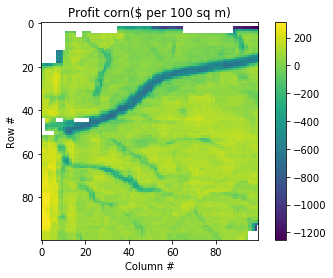

In [217]:
#####Annual crops####
profit_c = rasterio.open("profit_cs.tif")
print(profit_c.bounds)

# Convert the raster into a numpy array so that further calculations can be carried out
ar_profit_c = profit_c.read(1)

#Find maximum value of the numpy array, 
max_prof_c = np.nanmax(ar_profit_c)

#####Switchgrass#####      
profit_s=rasterio.open("profit_swg.tif")
ar_profit_s = profit_s.read(1)[:100, 100:200]
max_prof_s = np.nanmax(ar_profit_s)

max_prof= max(max_prof_c, max_prof_s) # select the extreme value of that indicator 

prof_norm_c = ar_profit_c/max_prof
prof_util_c=np.where(prof_norm_c<0, 0, prof_norm_c) # Specify that when unprofitable - zero utility

prof_norm_s = ar_profit_s/max_prof
prof_util_s = np.where(prof_norm_s<0, 0, prof_norm_s)

## Independence

Assume average corn subsidy of 100/ℎ𝑎 𝑔𝑖𝑣𝑒𝑛 a 800/ha profit without subsidy - score of 0.125 Assume average switchgrass subsidy as 100/ha for 2 years of establishment averaged over 10 years of total growth with 8 years of harvest given a 400/ha profit without subsidy - score of 0.25. The best score is 0, the worst score is 1


In [218]:
### Annual ####

env['ind_cs'] = 0.125
ind_cs = rasterize(env, "ind_cs.tif", env.ind_cs, template, outDir)
ind_util_c = (1-ind_cs)

### Switchgrass ####

env['ind_swg'] = 0.25
ind_swg = rasterize(env, "ind_swg.tif", env.ind_swg, template, outDir)
ind_util_s = (1-ind_swg)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}


## Financial stability

Based on the economic assessment, assume that corn profitability can vary between 25/ha to
850/ha with the score of 825 (assume that the profit is with subsidy, so crop subsidy mitigates some risk). Assume that switchgrass markets might not be functional, leading topaying the establishment cost but not getting the profit; thus the profit ranging from -400/ℎ𝑎 𝑡𝑜 400/ha to 800/ha in case of a good market with the score of 1200 Best score is 0, worst score is =(850/ℎ𝑎−(− 850/ha−(−1600/ha for corn establishment cost)) 2450


In [219]:
### Annual ####

env['fin_cs'] = 825
fin_cs = rasterize(env, "fin_cs.tif", env.fin_cs, template, outDir)
fin_util_c = (1-fin_cs/2450)

### Switchgrass ####

env['fin_swg'] = 1200
fin_swg = rasterize(env, "fin_swg.tif", env.fin_swg, template, outDir)
fin_util_s = (1-fin_swg/2450)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}


## Yield

Both inputs are provided based on the Google Earth Engine estimates. Often, farmers implied corn or soybean yield when discussing this priority, so in other versions of the model, yield for the "switchgrass" layer can be set to zero. 

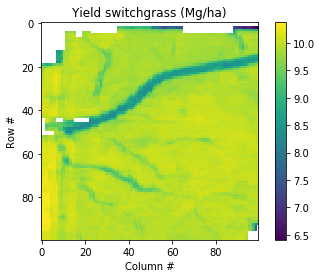

In [220]:
#####Annual crops####
yield_c = rasterio.open("yield_cs.tif")
# Convert the raster into a numpy array so that further calculations can be carried out
ar_yield_c = yield_c.read(1)

#Find maximum value of the numpy array, 
max_yield_c = np.nanmax(ar_yield_c)

####Switchgrass#####      
yield_s=rasterio.open("yield_swg.tif")
ar_yield_s = yield_s.read(1)
max_yield_s = np.nanmax(ar_yield_s)

max_yield= max(max_yield_c, max_yield_s) # select the extreme value of that indicator 

yie_util_c = ar_yield_c/max_yield
yie_util_s = ar_yield_s/max_yield

## Diversification

Based on the market assessment, assume indicator value 2 for annual crops and indicator value 4 for switchgrass. Assume the worst value is 0, the best value is 5 

In [221]:
### Annual ####

env['div_cs'] = 2
div_cs = rasterize(env, "div_cs.tif", env.div_cs, template, outDir)
div_util_c = (div_cs/5)

### Switchgrass ####

env['div_swg'] = 4
div_swg = rasterize(env, "div_swg.tif", env.div_swg, template, outDir)
div_util_s = (div_swg/5)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}


## Water quality

Nitrate runoff is based on other modeling efforts available in the literature and presented as raster file output. 

In [222]:
### Annual ####
wat_cs = rasterize(env, "wat_cs.tif", env.no3_cs, template, outDir)
max_wat_cs = np.nanmax(wat_cs)

### Switchgrass ####
wat_swg = rasterize(env, "wat_swg.tif", env.no3_swg, template, outDir)
max_wat_swg = np.nanmax(wat_swg)

max_wat = max(max_wat_swg, max_wat_cs)

wat_util_c = (1-wat_cs/max_wat)
wat_util_s = (1-wat_swg/max_wat)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}


## Wildlife and pristine nature

Based on Schulte et al. 2017, assume 1 for switchgrass and 0.33 (3 times less) for annual crops as based on species diversity estimates.

In [223]:
### Annual ####

env['wil_cs'] = 0.33
wil_cs = rasterize(env, "wil_cs.tif", env.wil_cs, template, outDir)
wil_util_c = wil_cs

### Switchgrass ####

env['wil_swg'] = 1
wil_swg = rasterize(env, "wil_swg.tif", env.wil_swg, template, outDir)
wil_util_s = wil_swg

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}


## CO2 emissions

Based on the FEAT model available in the literature, assume annual crop emissions are 2612 kgCo2e/yr/ha and 2293 kgCO2e/yr with 0 being the best value, 2612 - the worst.

In [224]:
### Annual ####

env['co2_cs'] = 2612
co2_cs = rasterize(env, "co2_cs.tif", env.co2_cs, template, outDir)
co2_util_c = (1-co2_cs/2612)

### Switchgrass ####

env['co2_swg'] = 2293
co2_swg = rasterize(env, "co2_swg.tif", env.co2_swg, template, outDir)
co2_util_s = (1-co2_swg/2612)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}


## Erosion potential

Water erosion rate was from models available in the literature where the output is presented as raster files.

In [225]:
### Annual ####
ero_cs = rasterize(env, "ero_cs.tif", env.watero_cs, template, outDir)
max_ero_cs = np.nanmax(ero_cs)

### Switchgrass ####
ero_swg = rasterize(env, "ero_swg.tif", env.watero_swg, template, outDir)
max_ero_swg = np.nanmax(ero_swg)

max_ero = max(max_ero_swg, max_ero_cs)

ero_util_c = (1-ero_cs/max_ero)
ero_util_s = (1-ero_swg/max_ero)



{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}


## Food production

The amount of land for food production. Assume 0 for switchgrass and 0.5 for annual crops. 

In [226]:
### Annual ####

env['food_cs'] = 0.5
food_cs = rasterize(env, "food_cs.tif", env.food_cs, template, outDir)
food_util_c = food_cs

### Switchgrass ####

env['food_swg'] = 0
food_swg = rasterize(env, "food_swg.tif", env.food_swg, template, outDir)
food_util_s = food_swg

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}


## Rural Development

The number of rural jobs. Assume that for corn: machine operator+ fertilizer/seed seller + co-op rep + farm manager/landowner = 4; for switchgrass: machine operator + seed seller + market 1 + market 2 + depot operator + farm manager/landowner = 6. The worst is 0 the best is 6

In [227]:
### Annual ####

env['rur_cs'] = 4
rur_cs = rasterize(env, "rur_cs.tif", env.rur_cs, template, outDir)
rur_util_c = rur_cs/6

### Switchgrass ####

env['rur_swg'] = 6
rur_swg = rasterize(env, "food_swg.tif", env.rur_swg, template, outDir)
rur_util_s = rur_swg/6



{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}


## Positive image

Consumer-approved practices. Assume 0.8 for switchgrass, 0.4 for corn.

In [228]:
### Annual ####

env['img_cs'] = 0.4
img_cs = rasterize(env, "img_cs.tif", env.img_cs, template, outDir)
img_util_c = img_cs

### Switchgrass ####

env['img_swg'] = 0.8
img_swg = rasterize(env, "img_swg.tif", env.img_swg, template, outDir)
img_util_s = img_swg

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}


## Farming lifestyle

Ability to maintain a family operation. Assumption: 0.5 for switchgrass and 0.3 for corn.

In [229]:
### Annual ####

env['lif_cs'] = 0.3
lif_cs = rasterize(env, "lif_cs.tif", env.lif_cs, template, outDir)
lif_util_c = lif_cs

### Switchgrass ####

env['lif_swg'] = 0.5
lif_swg = rasterize(env, "lif_swg.tif", env.lif_swg, template, outDir)
lif_util_s = lif_swg

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 435, 'height': 324, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.983152841195215e-05, 0.0, -94.5902637980469,
       0.0, -8.983152841195215e-05, 41.99390391284892)}


## Inheritability and young farmers

Land value as function of profit and management. Use as a sum of profit and soil organic carbon multiplied by 0.01 as a factor for improved land quality.

In [230]:
#####Annual crops####
factor_cs = soil_cs*0.01
inh_cs = np.add(ar_profit_c, factor_cs)
 
max_inh_c = np.nanmax(inh_cs)


factor_swg = soil_swg*0.01
inh_swg = np.add(ar_profit_s, factor_swg)
max_inh_s = np.nanmax(inh_swg)


max_inh = max(max_inh_c, max_inh_s)



inh_norm_c = inh_cs/max_inh
inh_util_c=np.where(inh_norm_c<0, 0, inh_norm_c) # Specify that when unprofitable - zero utility

inh_norm_s = inh_swg/max_inh
inh_util_s = np.where(inh_norm_s<0, 0, inh_norm_s)

# Utility evaluation

## Annual crop only

Total utility all corn/soybeans 4080.404733038932


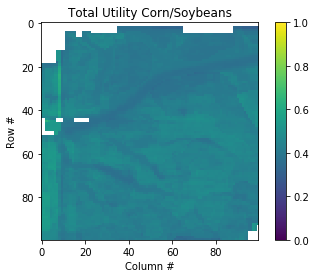

Soil quality utility for corn/soybeans 3305.5532170039896
Profitability utility for corn/soybeans 2015.773785371442
Independence utility for corn/soybeans 8806.75
Financial stability utility for corn/soybeans 6785.530612244899
Yield utility for corn/soybeans 8122.183063344403
Diversification utility for corn/soybeans 3818.4000000000005
Wildlife and pristine nature utility for corn/soybeans 3150.1800000000003
CO2 utility for corn/soybeans 454.0
Water quality utility for corn/soybeans 2174.0320913202668
Erosion potential utility for corn/soybeans 7856.643336529241
Food production utility for corn/soybeans 4773.0
Rural development utility for corn/soybeans 6363.999999999999
Positive image utility for corn/soybeans 3818.4000000000005
Farming lifestyle utility for corn/soybeans 2863.7999999999993
Inheritability and young farmers utility for corn/soybeans 2040.9074908659904


In [231]:
# Total utility
##Here is where the user can enter weights for each indicator relevant to them
weight_soil_c = soil_util_c*0.1
weight_prof_c = prof_util_c*0.133
weight_ind_c = ind_util_c*0
weight_fin_c = fin_util_c*0.133
weight_yie_c = yie_util_c*0.133
weight_div_c = div_util_c*0
weight_wil_c = wil_util_c*0
weight_co2_c = co2_util_c*0.1
weight_wat_c = wat_util_c*0.1
weight_ero_c = ero_util_c*0.1
weight_food_c = food_util_c*0
weight_rur_c = rur_util_c*0
weight_img_c = img_util_c*0.1
weight_lif_c = lif_util_c*0.1
weight_inh_c = inh_util_c*0


tot_util_c=weight_soil_c+weight_prof_c+weight_ind_c+weight_fin_c+weight_yie_c+weight_div_c+weight_wil_c+weight_co2_c+weight_wat_c+weight_ero_c+weight_food_c+weight_rur_c+weight_img_c+weight_lif_c+weight_inh_c

plt.imshow(tot_util_c)
print('Total utility all corn/soybeans',np.nansum(tot_util_c))
plt.colorbar()
plt.title('Total Utility Corn/Soybeans')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.clim(0,1)
plt.show()

print('Soil quality utility for corn/soybeans', np.nansum(soil_util_c))
print('Profitability utility for corn/soybeans', np.nansum(prof_util_c))
print('Independence utility for corn/soybeans', np.nansum(ind_util_c))
print('Financial stability utility for corn/soybeans', np.nansum(fin_util_c))
print('Yield utility for corn/soybeans', np.nansum(yie_util_c))
print('Diversification utility for corn/soybeans', np.nansum(div_util_c))
print('Wildlife and pristine nature utility for corn/soybeans', np.nansum(wil_util_c))
print('CO2 utility for corn/soybeans', np.nansum(co2_util_c))
print('Water quality utility for corn/soybeans', np.nansum(wat_util_c))
print('Erosion potential utility for corn/soybeans', np.nansum(ero_util_c))
print('Food production utility for corn/soybeans', np.nansum(food_util_c))
print('Rural development utility for corn/soybeans', np.nansum(rur_util_c))
print('Positive image utility for corn/soybeans', np.nansum(img_util_c))
print('Farming lifestyle utility for corn/soybeans', np.nansum(lif_util_c))
print('Inheritability and young farmers utility for corn/soybeans', np.nansum(inh_util_c))

# Convert the raster into a numpy array so that further calculations can be carried out
ar_profit_c = profit_c.read(1)

row_num = ar_profit_c.shape[0]
col_num = ar_profit_c.shape[1]

points=[]

## Switchgrass only

Total utility all switchgrass 4671.815531592435


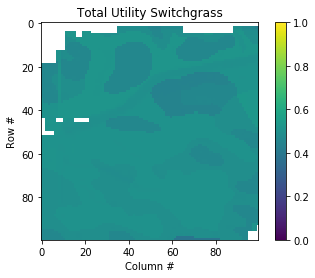

Soil quality utility for switchgrass 7417.768630234208
Profitability utility for switchgrass 0.0
Independence utility for switchgrass 7613.5
Financial stability utility for switchgrass 5324.408163265308
Yield utility for switchgrass 6113.0137260663705
Diversification utility for switchgrass 7636.800000000001
Wildlife and pristine nature utility for switchgrass 9546.0
CO2 utility for switchgrass 1619.839969372128
Water quality utility for switchgrass 4797.324574628474
Erosion potential utility for switchgrass 7692.300095877277
Food production utility for switchgrass 0.0
Rural development utility for switchgrass 9546.0
Positive image utility for switchgrass 7636.800000000001
Farming lifestyle utility for switchgrass 4773.0
Inheritability and young farmers utility for switchgrass 0.0


In [232]:
# Total utility
weight_soil_s = soil_util_s*0.1
weight_prof_s = prof_util_s*0.133
weight_ind_s = ind_util_s*0
weight_fin_s = fin_util_s*0.133
weight_yie_s = yie_util_s*0.133
weight_div_s = div_util_s*0
weight_wil_s = wil_util_s*0
weight_co2_s = co2_util_s*0.1
weight_wat_s = wat_util_s*0.1
weight_ero_s = ero_util_s*0.1
weight_food_s = food_util_s*0
weight_rur_s = rur_util_s*0
weight_img_s = img_util_s*0.1
weight_lif_s = lif_util_s*0.1
weight_inh_s = inh_util_s*0


tot_util_s=weight_soil_s+weight_prof_s+weight_ind_s+weight_fin_s+weight_yie_s+weight_div_s+weight_wil_s+weight_co2_s+weight_wat_s+weight_ero_s+weight_food_s+weight_rur_s+weight_img_s+weight_lif_s+weight_inh_s

plt.imshow(tot_util_s)
print('Total utility all switchgrass' ,np.nansum(tot_util_s) )
plt.colorbar()
plt.title('Total Utility Switchgrass')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.clim(0,1)
plt.show()

print('Soil quality utility for switchgrass', np.nansum(soil_util_s))
print('Profitability utility for switchgrass', np.nansum(prof_util_s))
print('Independence utility for switchgrass', np.nansum(ind_util_s))
print('Financial stability utility for switchgrass', np.nansum(fin_util_s))
print('Yield utility for switchgrass', np.nansum(yie_util_s))
print('Diversification utility for switchgrass', np.nansum(div_util_s))
print('Wildlife and pristine nature utility for switchgrass', np.nansum(wil_util_s))
print('CO2 utility for switchgrass', np.nansum(co2_util_s))
print('Water quality utility for switchgrass', np.nansum(wat_util_s))
print('Erosion potential utility for switchgrass', np.nansum(ero_util_s))
print('Food production utility for switchgrass', np.nansum(food_util_s))
print('Rural development utility for switchgrass', np.nansum(rur_util_s))
print('Positive image utility for switchgrass', np.nansum(img_util_s))
print('Farming lifestyle utility for switchgrass', np.nansum(lif_util_s))
print('Inheritability and young farmers utility for switchgrass', np.nansum(inh_util_s))


# Convert the raster into a numpy array so that further calculations can be carried out
ar_profit_c = profit_c.read(1)

row_num = ar_profit_c.shape[0]
col_num = ar_profit_c.shape[1]

points=[]

## Maximized pixel values

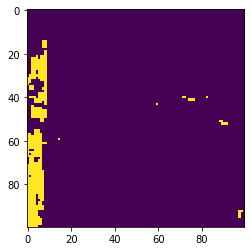

In [233]:
max_util = np.greater(tot_util_c, tot_util_s)
plt.imshow(max_util)

Total field utility: 4683.793569778185
Total field utility: 4683.793569778185
Total soil quality utility 7248.066444776192
Total profitability utility 274.3042957500676
Total independence utility 7664.25
Total financial stability utility 5386.551020408164
Total yield utility 6238.40806233531
Total diversification utility 7474.4000000000015
Total wildlife and pristine nature utility 9273.98
Total CO2 utility 1570.25574272588
Total water quality utility 4787.088304975232
Total erosion potential utility 7670.9539789069995
Total food production utility 203.0
Total rural development utility 9410.666666666666
Total positive image utility 7474.4000000000015
Total farming lifestyle utility 4691.8
Total inheritability and young farmers utility 274.8863457119887
Number of subfields: 20


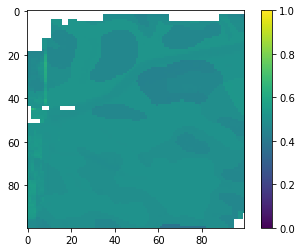

In [234]:
#Calculate the total utility given the crop plan - to be maximized
import numpy.ma as ma

cornsoy = ma.masked_where(max_util==0, tot_util_c)
switchgrass = ma.masked_where(max_util==1, tot_util_s)
field = ma.filled(cornsoy, switchgrass)
plt.imshow(field)
plt.colorbar()
plt.clim(0,1)
util = np.nansum(field)
print('Total field utility:', util)

#Calculate the total utility given the crop plan - to be maximized
import numpy.ma as ma
switchgrass=ma.masked_where(tot_util_s<tot_util_c, tot_util_s)
cornsoy=ma.masked_where(tot_util_s>tot_util_c, tot_util_c)
field=ma.filled(cornsoy, switchgrass)
fin_utility=np.nansum(field)
print('Total field utility:', fin_utility)

cornsoy = ma.masked_where(max_util==0, soil_util_c)
switchgrass = ma.masked_where(max_util==1, soil_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total soil quality utility', util)
      
cornsoy = ma.masked_where(max_util==0, prof_util_c)
switchgrass = ma.masked_where(max_util==1, prof_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total profitability utility', util)

cornsoy = ma.masked_where(max_util==0, ind_util_c)
switchgrass = ma.masked_where(max_util==1, ind_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total independence utility', util)

cornsoy = ma.masked_where(max_util==0, fin_util_c)
switchgrass = ma.masked_where(max_util==1, fin_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total financial stability utility', util)

cornsoy = ma.masked_where(max_util==0, yie_util_c)
switchgrass = ma.masked_where(max_util==1, yie_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total yield utility', util)

cornsoy = ma.masked_where(max_util==0, div_util_c)
switchgrass = ma.masked_where(max_util==1, div_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total diversification utility', util)

cornsoy = ma.masked_where(max_util==0, wil_util_c)
switchgrass = ma.masked_where(max_util==1, wil_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total wildlife and pristine nature utility', util)

cornsoy = ma.masked_where(max_util==0, co2_util_c)
switchgrass = ma.masked_where(max_util==1, co2_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total CO2 utility', util)

cornsoy = ma.masked_where(max_util==0, wat_util_c)
switchgrass = ma.masked_where(max_util==1, wat_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total water quality utility', util)

cornsoy = ma.masked_where(max_util==0, ero_util_c)
switchgrass = ma.masked_where(max_util==1, ero_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total erosion potential utility', util)

cornsoy = ma.masked_where(max_util==0, food_util_c)
switchgrass = ma.masked_where(max_util==1, food_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total food production utility', util)

cornsoy = ma.masked_where(max_util==0, rur_util_c)
switchgrass = ma.masked_where(max_util==1, rur_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total rural development utility', util)

cornsoy = ma.masked_where(max_util==0, img_util_c)
switchgrass = ma.masked_where(max_util==1, img_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total positive image utility', util)

cornsoy = ma.masked_where(max_util==0, lif_util_c)
switchgrass = ma.masked_where(max_util==1, lif_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total farming lifestyle utility', util)

cornsoy = ma.masked_where(max_util==0, inh_util_c)
switchgrass = ma.masked_where(max_util==1, inh_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)
print('Total inheritability and young farmers utility', util)


#Need to convert from float 64 format to int 32 to be able to process further
max_util = np.int32(max_util)

from rasterio.features import sieve, shapes
from shapely.geometry import Polygon, shape

#Print the number of shapes in the source raster
print("Number of subfields: %d" % len(list(shapes(max_util))))

## Smoothing heuristic + sieving

Total utility 4682.448356095204
Number of subfields: 5
Sieved switchgrass shapes: 1
Sieved corn shapes: 1
Sieved total shapes: 2
Sieved utility: 4679.349876399971
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
Average field efficiency: 0.8179277374061036


,geometry,value,perimeter,area,FE
0,"POLYGON ((3 55, 3 57, 2 57, 0 57, 0 100, 5 100...",1.0,1100.0,31600.0,0.665888
1,"POLYGON ((0 0, 0 57, 3 57, 3 55, 6 55, 6 57, 7...",0.0,4140.0,968400.0,0.969968


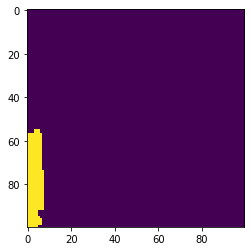

In [235]:
row_num = max_util.shape[0]
col_num = max_util.shape[1]
smoothed_util = max_util

#2 pixels over
for row in range (0, row_num-3):
    for col in range (0, col_num-1):
        if max_util[row, col] == max_util[row+3, col]:
            smoothed_util[row+1:row+2, col] = max_util[row, col]

for row in range (0, row_num-1):
    for col in range (0, col_num-3):
        if max_util[row, col] ==max_util[row, col+3]:
            smoothed_util[row, col+1:col+2]=max_util[row, col]
            
plt.imshow(smoothed_util)    

cornsoy = ma.masked_where(smoothed_util==0, tot_util_c)
switchgrass = ma.masked_where(smoothed_util==1, tot_util_s)
field = ma.filled(switchgrass, cornsoy)
util = np.nansum(field)

print('Total utility', util)

from rasterio.features import sieve, shapes
import matplotlib.patches as mpatches

#Need to convert from float 64 format to int 32 to be able to process further
smoothed_util = np.int32(smoothed_util)

#Print the number of shapes in the source raster
print("Number of subfields: %d" % len(list(shapes(smoothed_util))))

#Create masks for corn and switchgrass to sieve out the subfields - small for switchgrass, large for corn
sieve20 = sieve(smoothed_util, 20, connectivity=4)
mask_s2=ma.masked_where(sieve20==[True],sieve20)

sieve150 = sieve(smoothed_util, 150, connectivity=4)
mask_c2 = ma.masked_where(sieve150==[False], sieve150)

sieved_field=ma.filled(mask_s2, mask_c2)

non_sieved2=len(list(shapes(mask_s2)))
print("Sieved switchgrass shapes: %d" % non_sieved2)
sieved2=len(list(shapes(mask_c2)))#
print("Sieved corn shapes: %d" % sieved2)

sieved_switchgrass=ma.masked_where(sieved_field==0,tot_util_c)
sieved_cornsoy=ma.masked_where(sieved_field==1,tot_util_s)
sieved_util=ma.filled(sieved_cornsoy, sieved_switchgrass)

sieved_tot=len(list(shapes(sieved_field)))
print("Sieved total shapes: %d" % sieved_tot)
print("Sieved utility:", np.nansum(sieved_util))

plt.imshow(sieved_field)
print(sieved_field)

from rasterio.features import sieve, shapes
from shapely.geometry import Polygon,shape

shapes= shapes(sieved_field, connectivity=4)
gdf = gpd.GeoDataFrame(shapes)
gdf.columns = ['geometry', 'value']
for index,row in gdf.iterrows():
    gdf.loc[index,'geometry']=shape(gdf.loc[index,'geometry'])
gdf['perimeter']=(gdf['geometry'].length)*10
gdf['area']=(gdf['geometry'].area)*100
gdf['FE'] =0.179-0.145*np.log(gdf['perimeter']/gdf['area']) 
print ('Average field efficiency:', gdf["FE"].mean())
gdf